In [23]:
%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121


Looking in indexes: https://download.pytorch.org/whl/cu121
Note: you may need to restart the kernel to use updated packages.


In [12]:
%pip install pytorch-forecasting pytorch-lightning scikit-learn matplotlib numpy pandas

Note: you may need to restart the kernel to use updated packages.


In [1]:
# ------------------ 0. Imports ------------------
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, WeightedRandomSampler
import matplotlib.pyplot as plt
import seaborn as sns

from pytorch_forecasting import TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import NaNLabelEncoder
from lightning.pytorch import Trainer
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchmetrics import Metric
# ------------------ 0.1 Set Random Seed Everywhere ------------------
import random

def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if using multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(42)

class FocalLoss(nn.Module):
    def __init__(self, alpha=0.9, gamma=8.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets.float(), reduction='none')
        pt = torch.exp(-BCE_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * BCE_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

class FocalLossMetric(Metric):
    def __init__(self, alpha=0.9, gamma=8.0):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.focal_loss = FocalLoss(alpha, gamma)
        
        # Initialize state variables to accumulate results across steps
        self.add_state("total_loss", torch.tensor(0.0), dist_reduce_fx="sum")
        self.add_state("count", torch.tensor(0), dist_reduce_fx="sum")

    def update(self, preds, target):
        # Calculate loss for current batch and accumulate
        loss = self.focal_loss(preds, target)
        self.total_loss += loss
        self.count += 1

    def compute(self):
        # Return the average loss across all updates
        return self.total_loss / self.count

    def reset(self):
        # Reset state variables at the start of a new epoch
        self.total_loss.fill_(0)
        self.count.fill_(0)




/media/rohan/c79d22f9-b491-4e0f-8248-6ca5b671d076/major_project2/.venv/lib/python3.12/site-packages/pytorch_forecasting/models/base_model.py:27: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [2]:

# ------------------ 1. Load and preprocess data ------------------
data = pd.read_csv("/media/rohan/c79d22f9-b491-4e0f-8248-6ca5b671d076/major_project2/rainfall_with_correct_flood_labels.csv")
data["location_id"] = data["LATITUDE"].astype(str) + "_" + data["LONGITUDE"].astype(str)

data["TIME"] = pd.to_datetime(data["TIME"])
data = data.sort_values(["location_id", "TIME"]).reset_index(drop=True)
data["time_idx"] = (data["TIME"] - data["TIME"].min()).dt.days
data["DISTRICT"] = data["DISTRICT"].astype("category")

# ------------------ 2. Train/Validation Split ------------------
train_cutoff = data["time_idx"].quantile(0.7).astype(int)
training = data[data["time_idx"] < train_cutoff]  # Use time_idx for splitting
validation = data[data["time_idx"] >= train_cutoff]  # Use time_idx for splitting


In [ ]:


# ------------------ 3. Define TimeSeriesDataSet ------------------
max_encoder_length = 90
max_prediction_length = 50

training_dataset = TimeSeriesDataSet(
    training,
    time_idx="time_idx",
    target="FLOOD",
    group_ids=["location_id"],
    static_categoricals=["location_id"],
    static_reals=["LATITUDE", "LONGITUDE"],
    time_varying_known_categoricals=["DISTRICT", "STATE"],
    time_varying_known_reals=["RAINFALL"],
    time_varying_unknown_reals=["FLOOD"],
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,
    target_normalizer=NaNLabelEncoder(),
    allow_missing_timesteps=True,
)

validation_dataset = TimeSeriesDataSet.from_dataset(
    training_dataset, data, predict=True, stop_randomization=True
)

# Extract the underlying pandas dataframe used to create the TimeSeriesDataSet
y_train = data[data["time_idx"] <= train_cutoff]["FLOOD"].astype(int)


# Handle imbalance
counts = np.bincount(y_train)
pos_weight = torch.tensor(counts[0] / counts[1], dtype=torch.float)
# Align sample weights to the windows in training_dataset

sample_weights = []
for idx in training_dataset.index.iterrows():
    # idx[1]['index_end'] points to last time step
    flood_value = data.loc[idx[1]['index_end'], "FLOOD"]
    sample_weights.append(pos_weight.item() if flood_value == 1 else 1.0)

sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

# sample_weights = np.where(y_train == 1, pos_weight.item(), 1.0)
# sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

#------------------ 4. Handle class imbalance ------------------


# ------------------ 5. Dataloaders ------------------
batch_size = 256
train_loader = training_dataset.to_dataloader(
    train=True,
    batch_size=batch_size,
    sampler=sampler,
    shuffle=False,  # because sampler is handling sampling
    num_workers=4,
)
val_loader = validation_dataset.to_dataloader(train=False, batch_size=batch_size, num_workers=4)
loss_fn = FocalLossMetric(alpha=0.9, gamma=8.0)
print(f"Training Loader Length: {len(train_loader.dataset)}")
print(f"Validation Loader Length: {len(val_loader.dataset)}")

# ------------------ 6. Model Setup (with Focal Loss) ------------------
model = TemporalFusionTransformer.from_dataset(
    training_dataset,
    learning_rate=0.001,
    hidden_size=256,
    attention_head_size=16,
    dropout=0.1,
    hidden_continuous_size=8,
    output_size=1,
    loss=loss_fn,
    log_interval=10,
    reduce_on_plateau_patience=4,
)

# ------------------ 7. Trainer ------------------
trainer = Trainer(
    max_epochs=10,
    gradient_clip_val=0.1,
    callbacks=[
        EarlyStopping(monitor="val_loss", patience=1, mode="min"),
        LearningRateMonitor(logging_interval='epoch'),
    ],
    accelerator="auto",
    devices="auto",
)

# ------------------ 8. Training ------------------
trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=val_loader)


/media/rohan/c79d22f9-b491-4e0f-8248-6ca5b671d076/major_project2/.venv/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/media/rohan/c79d22f9-b491-4e0f-8248-6ca5b671d076/major_project2/.venv/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/media/rohan/c79d22f9-b491-4e0f-8248-6ca5b671d076/major_project2/.venv/lib/python3.12/site-

Training Loader Length: 1003612
Validation Loader Length: 130



   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | TorchMetricWrapper              | 0      | train
1  | logging_metrics                    | ModuleList                      | 0      | train
2  | input_embeddings                   | MultiEmbedding                  | 3.2 K  | train
3  | prescalers                         | ModuleDict                      | 64     | train
4  | static_variable_selection          | VariableSelectionNetwork        | 13.0 K | train
5  | encoder_variable_selection         | VariableSelectionNetwork        | 14.8 K | train
6  | decoder_variable_selection         | VariableSelectionNetwork        | 8.5 K  | train
7  | static_context_variable_selection  | GatedResidualNetwork            | 263 K  | train
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 263 K  

Epoch 1: 100%|██████████| 3920/3920 [31:22<00:00,  2.08it/s, v_num=62, train_loss_step=2.27e-5, val_loss=0.00137, train_loss_epoch=2.91e-5]  


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--- Classification Report ---
              precision    recall  f1-score   support

           0     0.9950    0.8630    0.9243      6453
           1     0.0210    0.4043    0.0400        47

    accuracy                         0.8597      6500
   macro avg     0.5080    0.6336    0.4822      6500
weighted avg     0.9880    0.8597    0.9179      6500



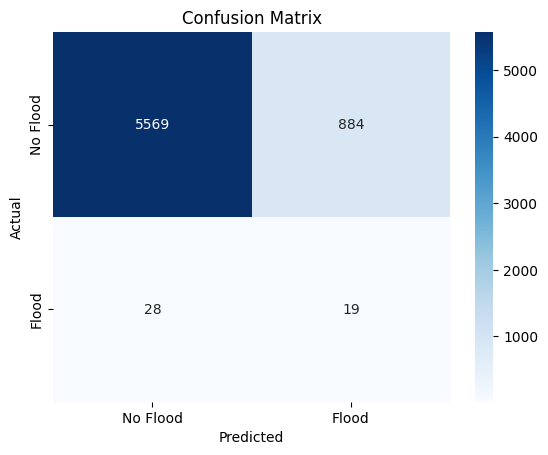

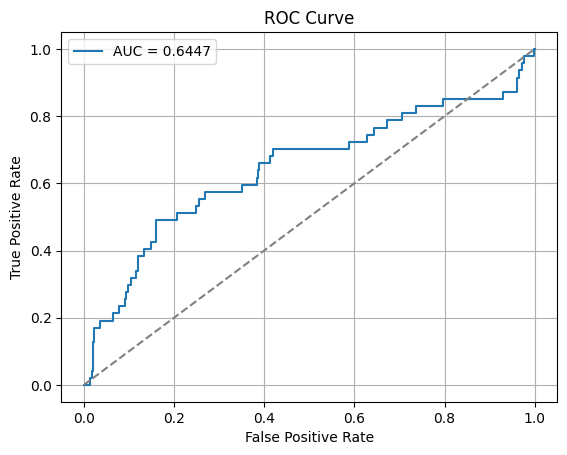

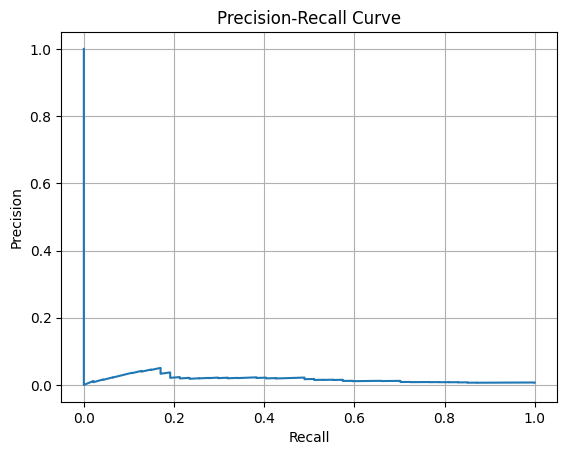

Accuracy: 0.8597


In [7]:

# Get the Prediction object
predictions = model.predict(val_loader, mode="raw", return_x=True)

# Extract outputs
raw_preds = predictions.output.prediction  # this is what you need to sigmoid
x = predictions.x  # contains your true labels and features

# Now continue with evaluation
pred_probs = torch.sigmoid(raw_preds).view(-1).detach().cpu().numpy()
true_labels = x["decoder_target"].view(-1).detach().cpu().numpy()
pred_labels = (pred_probs >= 0.3).astype(int)

# ---------------------- Evaluation ----------------------
print("\n--- Classification Report ---")
print(classification_report(true_labels, pred_labels, digits=4))

# Confusion Matrix
cm = confusion_matrix(true_labels, pred_labels)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["No Flood", "Flood"], yticklabels=["No Flood", "Flood"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(true_labels, pred_probs)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(true_labels, pred_probs):.4f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid()
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(true_labels, pred_probs)
plt.plot(recall, precision)
plt.title("Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.grid()
plt.show()
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(true_labels, pred_labels)
print(f"Accuracy: {accuracy:.4f}")

# Save full model
trainer.save_checkpoint("tft_model.ckpt")
